In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import VAR
import copy

# Set data folder path
files_path = "DataFiles/"

# 1. Regression Methods
## 1.1 Processing stock price data in Python
### 1.1.1 Price Log Transform

In [ ]:
px = pd.read_csv("DataFiles/priceData.csv")
px = px.dropna() # Remove NaN entries which cause graphs to be incomplete
px['date'] = pd.to_datetime(px['date'], dayfirst=True)
px.set_index(['date'], inplace=True)
logpx = px.copy()
logpx['SPX Index'] = np.log(logpx['SPX Index'])


The graphs below show the SPX index since the 1930s, the left shows the absolute value while the right shows the log value

In [ ]:
fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)

px.plot(ax=axes[0], grid=True, title='SPX Index', legend=False, xlabel='Date');
logpx.plot(ax=axes[1], grid=True, title='Log SPX Index', legend=False, xlabel='Date');

### 1.1.2 Sliding window price time-series
#### Mean
The graphs below show the sliding window time series for the SPX index. The graph on the left is the absolute value and has no stationarity as its mean gows exponentially from the 1930s to the 1990s. An argument could be made that it became somewhat stationary between the late 1990s and the mid 2010s however the variance of such a distribution would be too high to make any meaningful conclusions. 

The log graph is also non-stationary, however its rise in mean is much more smoother than the alternative. The segment between the late 1990s and mid 2010s could also been seen as stationary with a much lower variance than before.

In [ ]:
# Size of sliding window
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)


px.rolling(window).mean().plot(ax=axes[0], grid=True, title='SPX Index | Sliding Window | mean', legend=False, xlabel='Date');
logpx.rolling(window).mean().plot(ax=axes[1], grid=True, title='Log SPX Index | Sliding Window | mean', legend=False, xlabel='Date');

#### Standard Deviation
The standard devation graphs below show much more stationarity than the mean graphs, especially the log SPX index. Said, graph seems to have a constant means around 0.75 with a large variance. The absolute graph, shown on the left, has an increasing mean making it essentially non-stationary.

In [ ]:
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)
px.rolling(window).std().plot(ax=axes[0], grid=True, title='SPX Index | Sliding Window | s.d.', legend=False, xlabel='Date');
logpx.rolling(window).std().plot(ax=axes[1], grid=True, title='Log SPX Index | Sliding Window | s.d.', legend=False, xlabel='Date');

### 1.1.3 Simple and Log Returns
Below are the simple and log returns of the SPX index.

In [ ]:
logret = logpx.copy()
logret['SPX Index'] = logret['SPX Index'].diff()

simret = px.copy()
simret['SPX Index'] = simret['SPX Index'].pct_change()

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)

simret.plot(ax=axes[0], grid=True, title='SPX Index', legend=False, xlabel='Date');
logret.plot(ax=axes[1], grid=True, title='Log SPX Index', legend=False, xlabel='Date');

#### Sliding Window: Mean
As before, we take a sliding window of size 252, of the data and plot the mean and s.d. The graphs shown below represent the mean of the sliding window for both simple and log returns. As can be seen, the mean of both graphs is much more constant meaning thay they have more stationarity than the price graphs shown before. They are also much more similar to each other than the log price and normal price graphs were

In [ ]:
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)
simret.rolling(window).mean().plot(ax=axes[0], grid=True, title='SPX Index | Simple Returns | Sliding Window | mean', legend=False, xlabel='Date');
logret.rolling(window).mean().plot(ax=axes[1], grid=True, title='SPX Index | Log Returns | Sliding Window | mean', legend=False, xlabel='Date');

#### Standard Deviation
As with the mean, the standard deviation plots of the returns show more stationarity than the price plots.

In [ ]:
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)

simret.rolling(window).std().plot(ax=axes[0], grid=True, title='SPX Index | Simple Returns | Sliding Window | s.d.', legend=False, xlabel='Date');
logret.rolling(window).std().plot(ax=axes[1], grid=True, title='SPX Index | Log Returns | Sliding Window | s.d.', legend=False, xlabel='Date');

In [ ]:
# Do some jarque-bera tests

### 1.1.4 Advantages of Log Returns
If we assume prices in the short term are distributed log-normally, then the log return is normally distributed. This is advantageous because many statistcal and signal processing methods assume Gaussianity. Log returns are also time-additive which means that when calculating the compounding return of a sequence of trades the caluclation becomes much simpler. If we use the identity: $ log(1+r_i) = log(\frac{p_i}{p_{i-1}})  = log(p_i) - log(p_{i-1}) $, then we can simplfy the as such: $\sum_{i}^{n} log(1+r_i) = log(1+r_1) + log(1+r_2) + ... + log(1+r_n) = log(p_n) - log(p_0) $.

To confirm the Gaussianity of data we may use the Jarque-Bera test, which returns a statistic. The closer this statistic, JB, is to zero the more normal the distribution of data points is. The graph below shows that as more data points are introduced the distribution becomes less Gaussian which is to be expected as the mean of the SPX index is constantly increasing.



In [ ]:
JB_results = pd.DataFrame()
JB_results['log'] = [stats.jarque_bera(logret.dropna()[:i])[0] for i in range (100, len(logret.dropna()), 100)]
JB_results['simple'] = [stats.jarque_bera(simret.dropna()[:i])[0] for i in range (100, len(simret.dropna()), 100)]
x = [i for i in range (100, len(simret), 100)]
JB_results['Data Points'] = x
JB_results.set_index('Data Points', inplace=True)
fig, axes = plt.subplots(1)
fig.set_figwidth(15)


JB_results.plot(ax=axes, grid=True, title='', xlabel='Data Points', y=['log','simple'], ylabel='JB Score');



### 1.1.5 Simple vs Log Return: Calculation
Given the example, that if we were to purchase a stock for £1 and the next day the value goes up to £2 and the day after it goes back to £1 we can calculate the simple and log returns over the two days. The simple returns would be [1, -0.5] (1st element is the returns for day 1, 2nd element is returns for day 2). The log returns is [0.69, -0.69]. By summing the log returns we get 0, which tells us that the value of the stock hasn't changed over two days which is more information than the simple returns. 

### 1.1.6 Simple vs Log Return: Simple Returns Adv.
Since log-normality of data points only hold for short time periods we can only use log returns for short-term analysis. Additionally, while log returns are time-additive they cannot be added across assets, thus we need simple returns for portfolio analysis.


## 1.2 ARMA vs. ARIMA Models for Financial Applications
### 1.2.1 ARMA vs ARIMA Suitability
In this section we take the closing prices for the S&P 500 over the last 4 years and follow the process in Section 1.1.1 to find the log of the prices.

In [ ]:
# ARMA vs ARIMA
snp = pd.read_csv(files_path+'snp_500_2015_2019.csv')
snp['Date'] = pd.to_datetime(snp['Date'], dayfirst=True)
snp.set_index(['Date'], inplace=True)
snp_close = snp['Close'].to_frame()
snp_log_close = snp['Close'].to_frame().apply(np.log)

In [ ]:
fig, axes = plt.subplots(1)
fig.set_figwidth(15)
snp_log_close.plot(ax=axes, grid=True, title='S&P 500 | Log Closing Value', legend=False, xlabel='Date');

In [ ]:
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)


snp_log_close.rolling(window).mean().plot(ax=axes[0], grid=True, title='Log S&P Closing | Sliding Window | mean', legend=False, xlabel='Date');
snp_log_close.rolling(window).std().plot(ax=axes[1], grid=True, title='Log S&P Closing | Sliding Window | mean', legend=False, xlabel='Date');

As can be seen from the log, sliding window mean and s.d. plots none of the data is stationary and thus an ARIMA model would be more appropirate to analyse this data

### 1.2.2 ARMA(1,0) Model
The figure below shows the predicted signal from an ARMA model based on the data above. In order to better show the how the data relates to the true value, the true value was overlayed on the graph, and only small window of time is shown. As you can see the model tends to lag behind the true value, but generally predicts the correct trends. In reality this  day delay would make the model only useful for long term modelling as any individuals interested in predicting values for a day by day basis would end up missing daily peaks and troughs. Finally, this model would also be unable to accomodate for large fluctations in the market.

In [ ]:
snp_arma = snp_log_close.copy()
snp_arma.columns = ['True']
snp_arma['Res'] = ARIMA(snp_arma['True'].values, order=(1,0,0)).fit().resid
snp_arma['Prediction'] = snp_arma['True'] - snp_arma['Res']

fig, axes = plt.subplots(1)
fig.set_figwidth(15)

snp_arma[:100].plot(ax=axes, grid=True, title='S&P 500 | ARMA: Order(1,0) ', y=['Prediction','True']);

print('Model Parameters: ', ARIMA(snp_arma['True'].values, order=(1,0,0)).fit().arparams)

### 1.2.3 ARIMA(1,1,0) Model
Modelling the same data, now with an ARIMA(1,1,0) model, shows a similar result. This model doesn't have a large initial prediction like ARMA's, but does lag behind by a day compared to the true value, rendering it somewhat unusable for day trading. On the plus side the AR parameter for this model is -0.00875, which is less than 1 meaning that the prediction has some stationarity to it.

In [ ]:
snp_arima = snp_log_close.copy()
snp_arima.columns = ['True']
snp_arima['Res'] = np.concatenate((np.array([0]),ARIMA(snp_arima['True'].values, order=(1,1,0)).fit().resid))
snp_arima['Prediction'] = snp_arima['True'] - snp_arima['Res']

fig, axes = plt.subplots(1)
fig.set_figwidth(15)

snp_arima[:100].plot(ax=axes, grid=True, title='S&P 500 | ARIMA: Order(1,1,0) ', y=['Prediction','True']);
print('Model Parameters: ', ARIMA(snp_arima['True'].values, order=(1,1,0)).fit().arparams)
print('Avg. Error: ', (snp_arima['Res'].abs().divide(snp_arima['True']).mean()))

### 1.2.4 Log Prices and ARIMA
To evaluate the neccessity of using log prices when using an ARIMA model, we will create an ARIMA model using the normal price values and compare the difference in mean residuals. The figure below shows how the ARIMA model using normal prices performs. Since the range of data for the log ARIMA model and normal ARIMA model are vastly different, comparing the absolute value of the residuals wouldn't yield and helpful information. Instead we think of the residuals as the error value, and divide them by the true value to find the error percentage, this then allows for a much more meaningful comparison. The ARIMA model based on the log values has an average error of 0.076% where as the ARIMA model based on the normal values has an average error of 0.58%, nearly an order of magnitude higher. Thus in order to keep residuals much more accurate we need to use log prices.

In [ ]:
snp_arima_norm = snp_close.copy()
snp_arima_norm.columns = ['True']
snp_arima_norm['Res'] = np.concatenate((np.array([0]),ARIMA(snp_arima_norm['True'].values, order=(1,1,0)).fit().resid))
snp_arima_norm['Prediction'] = snp_arima_norm['True'] - snp_arima_norm['Res']

fig, axes = plt.subplots(1)
fig.set_figwidth(15)

snp_arima_norm[:100].plot(ax=axes, grid=True, title='S&P 500 | ARIMA: Order(1,1,0) ', y=['Prediction','True']);

print('Model Parameters: ', ARIMA(snp_arima_norm['True'].values, order=(1,1,0)).fit().arparams)
print('Avg. Error: ', (snp_arima_norm['Res'].abs().divide(snp_arima_norm['True']).mean()))

## 1.3 VAR Models

### 1.3.1 

In order to simplify the equation:  
$y_t = c + A_1y_{t-1} + A_2y_{t−2} + \cdots + A_py_{t−p} + e_t$  
into  
$Y = BZ + U$  
We must reason what the four matricies must be.  
  
$Y$ is a list of all outputs for all variables at all time points:  
$Y = \begin{bmatrix} y_t & y_{t+1} & \cdots & y_{t+T} \end{bmatrix} \in \mathbb{R}^{K\times T}$  
Each $y_t$ is a vector of size $K$, which is equal to the number of variables.
  
$B$ is a matrix containing all of the coefficients represented as $A$ in the original equation along with the constant $c$:  
$B = \begin{bmatrix} c & A_1 & A_2 & \cdots & A_p \end{bmatrix} \in \mathbb{R}^{K \times (KP + 1)}$
  
$Z$ contains all the values of $y$ at different time points:  
$Z = \begin{bmatrix}
    1 & 1 & \cdots & 1 \\
    y_{t-1} & y_{t} & \cdots & y_{t-1+T} \\
    y_{t-2} & y_{t-1} & \cdots & y_{t-2+T} \\
    \vdots & \vdots & \ddots & \vdots \\
    y_{t-p} & y_{t-p+1} & \cdots & y_{t-p+T} \\
\end{bmatrix} \in \mathbb{R}^{(KP + 1) \times T}$

Finally, $U$ contains all the error terms represented by $e_t$ in the original equation:  
$U = \begin{bmatrix} e_t & e_{t+1} & \cdots & e_{t+T} \end{bmatrix} \in \mathbb{R}^{K\times T}$  

Thus we can simply to the concise matrix form: $Y = BZ + U$.  
Where:  
  
$Y \in \mathbb{R}^{K\times 1}$  

$B \in \mathbb{R}^{K \times (KP + 1)}$

$Z \in \mathbb{R}^{(KP + 1) \times T}$  

$U \in \mathbb{R}^{K\times 1}$



### 1.3.2 Optimal Coefficient
To find the solution to $Y = BZ + U$, we can use a multi-variate least-squares method and attempt minimize $U$ which contains the error terms. Thus we rearrange and minimuse $UU^T$
  
$min\:UU^T = (Y-BZ)(Y-BZ)^T$   
$min\:UU^T = YY^T - 2YZ^TB^T + BZZ^TB^T$  
$\frac{\partial UU^T}{\partial B} = 2BZZ^T - 2YZ^T = 0$  
$ BZZ^T = YZ^T $  
thus the optimal value for $B$ is:  
$B = YZ^T(ZZ^T)^{-1}$

### 1.3.3 Eigenvalues of a VAR
A simple VAR(1) process can be written as:  
$y_t = Ay_{t-1} + e_t$  
By expanding $y_{t-1}$, $p$ times recursively we can represent the equation as:  
$y_t = A^py_{t_p} + \sum_i^{p-1}A^ie_{t-i}$  
Since it follows that $A^px = \lambda^px$ where $\lambda$ is the eigenvalue of $A$, if an eigenvalue of A is larger than 1 then $y$ will very quickly go to infinity

### 1.3.4 Portfolio Optimisation
In this section we investigate method of analysing portfolios to see if they are diversified. In the first part we shall take five stocks from the SNP(CAG, MAR, LIN, HCP and MAT) and fit a VAR(1) model on them. The figures below show the values of the stocks between 2015 and 2019, aswell as the detrended stock values which essentitally only plots the variance around a 66 rolling day mean. LIN only started trading in mid 2018 and thus all of the detrended data starts from that point aswell.

In [ ]:
all_stocks = pd.read_csv(files_path+'snp_allstocks_2015_2019.csv')

all_stocks['Date'] = pd.to_datetime(all_stocks['Date'], dayfirst=True)
all_stocks.set_index(['Date'], inplace=True)

info = pd.read_csv(files_path+'snp_info.csv')
info.drop(columns=info.columns[0], inplace=True)

In [ ]:
tickers = ['CAG', 'MAR', 'LIN', 'HCP', 'MAT'] # What we're interested in
stocks = all_stocks[tickers]

# Detrend using a moving average of 66 (3*22 i.e. one quarter)
stocks_ma = stocks.rolling('66d').mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

# Create model
model = VAR(stocks_detrended)
results = model.fit(1)
A =  results.params[1:].values
eigA, eigVA = np.linalg.eig(A)

In [ ]:
fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)



stocks_ma.plot(ax=axes[0], grid=True, title='Stock Value | Sliding Window | Mean');
stocks_detrended.plot(ax=axes[1], grid=True, title='Detrended Stock Value | Sliding Window | Mean');

In [ ]:
results.params[1:]

The table above shows the parameters for the model, or in terms of the equations we talked about previously, the matrix $A$. The diagonal has the highest value across the board, which makes sense because the lagged value of a single stock has the biggest impact on itself i.e. the price of CAG at $t-1$ has the most impact on it's price at $t$ than all of the other stocks. Thus, we can read this matrix as somewhat of a covariance matrix, where higher magnitudes indicate more dependence between stocks and the sign represents positive or negative correlation.

One rule of covariance matricies is that the eigenvalues of the matrix equal the variance across that eigenvector, thus we can deduce that if the eigenvalues are all similar there is very little correlation across the entire data.

#### Eigenvalues of portfolio  

| Min | Max | Mean |
| --- | --- | --- |
| 0.942 | 0.979 | 0.966 |

As can be seen this portfolio is largely uncorrelated and thus can be considered diversified which is what we want from a portfolio.

### 1.3.5 Sector Portfolios
Generally speaking having creating a portfolio with only one sector is ill-advised due to the stocks having similar risks. For example a legislation on oil companies may cause the stock of all oil companies to fall. In mathematical terms we would say that sector specific portfolios are highly corellated. Using a similar methodology from the previous question we can veryify this claim by  fitting stocks from a single sector on a VAR and then finding the eigenvalues of the model parameters.

The table below show the result of such analysis and as can been seen, the variance of eigenvalues for most sectors is extremely high, thus proving the stocks within that portfolio are highly correllated. The exception to this rule would be Communication Services, Real Estate, and Energy which seem to be less correlated than the other sectors but still more than the example portfolio in the previous question.

Thus, if one did want to diversify their portfolio and reduce correlation across stocks it would be better to choose stocks from differing industries.

In [ ]:
eigArray = pd.DataFrame(index=info['GICS Sector'].unique(), columns=['min eigenvalue', 'mean eigenvalue', 'max eigenvalue'])

for sector in info['GICS Sector'].unique():
    tickers = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    stocks = all_stocks[tickers].dropna()

    stocks_ma = stocks.rolling('66d').mean()
    stocks_detrended = stocks.sub(stocks_ma).dropna()

    # Create model
    model = VAR(stocks_detrended)
    results = model.fit(1)
    A =  results.params[1:].values
    eigA, _ = np.linalg.eig(A)

    eigArray.at[sector, 'min eigenvalue'] = np.min(abs(eigA))
    eigArray.at[sector, 'mean eigenvalue'] = np.mean(abs(eigA))
    eigArray.at[sector, 'max eigenvalue'] = np.max(abs(eigA))
eigArray


# 2. Bond Pricing
## 2.1 Basic Bond Pricing
### 2.1.1
The formula for investement return is $ R = I * (1 + \frac{r}{k})^k $, where $R$ is the investment return, $I$ is the initial investment, $r$ is the annual risk free rate and $k$ is how often the return is paid per year. Assuming $R = 1100$ and $I = 1000$ we can calculate $r$ for different $k$ values by rearranging the formula: $ r = ((\frac{R}{I})^{\frac{1}{k}} - 1) * k $  
  
a) $k = 1$, Annual compounding: $ r = 10\%$  
b) $k = 2$, Bi-annual compounding: $ r = 9.76\%$
c) For continuous compounding we use use $ R = I * e^r$, which rearranged gives us, $r = \log \frac{R}{I} = 9.53\% $

### 2.1.2
Assume we invest £100 initialy, $I = 100$, and that $r = 0.15$ with $k = 12$(monthly compounding). In this case $R = 116.07$. To get the same value with continuous compounding we would need $r = \log \frac{R}{I} = 14.91\% $

### 2.1.3
When, $I = 1000$, $r = 0.12$ and we use continuous compounding, $R = 1127.50$. If we assume this is the final return from a year of investement but with the returns being paid quarterly, we can calculate our new value for $r$, $r = ((\frac{R}{I})^{\frac{1}{k}} - 1) * k = 12.18\% $. Thus, the returns per quarter would be : \$30.45, \$31.38, \$32.33, \$33.32, respectively

## 2.2 Forward Rates

### 2.2.1 
a) Deciding on whether or not the extra 9% is worthwhile for the user is dependent on how much they think they can earn in other markets in the second year. If, an individual thinks they are able to earn more than 9% in a different market they should invest for 1 year at 5% and then take their profits and invest elsewhere.

b) Once again, the choice of investement strategies should only be taken after an analysis of other markets is considered.

c) The forward rate is the return needed in the 2nd year if one wanted to match the 2 year 7% strategy after taking the 1 year 5% strategy. The advantage of such a strategy is that potentially the individual could earn more that 9%, but they could also earn less. The risk one takes on by becoming dependent on what the rates will actually be in a years time is both the advantage and disadvantage.


## 2.3 Duration of coupon-bearing bonds

### 2.3.1 
a)We simply add up the final row in the table to get the duration.
Duration = $0.0124+0.0236+0.0337+0.0428+0.0510+0.0583+6.537=6.7595$ 

b) Since, modifed duration $= \frac{Duration}{1+yield}$ where yield is 5%, the modifed duration = 6.4376%. This value is slightly lower than the normal duration. Since the modifed duration measures how much the normal duration changes based on the yield it can be used a risk measure to see how this bond will hold up to changing interest rates.

## 2.4 Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT)

### 2.4.1
Generally, the market stays close to zero as can be seen in the figures below. Thus lending to the idea of diversification in order to reduce risk.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import VAR
import copy


In [ ]:
allvals = pd.read_csv('DataFiles/fsp_case_31_BSD.csv', index_col=0,header=[0 ,1]).dropna(1)
allvals.index = pd.to_datetime(allvals.index)
df = allvals['ret'].copy() # remove na entries
non_weighted_mean = df.mean(1) # calculate mean for that day
fig, axes = plt.subplots(2,1)
fig.set_figwidth(15)
df.plot(ax=axes[0], legend=False , grid=True, ylim=[-0.5,0.5], title='Returns across all stock');
non_weighted_mean.plot(ax=axes[1], grid=True, ylim=[-0.03,0.03], title='Market returns');
fig.subplots_adjust(hspace=0.6)


### 2.4.2 Rolling beta

As can be seen from the rolling window plot, the market generally centres itself around the β = 1 line, meaning that any risk in investing into the market can be reduced by diversification. There are some peaks and troughs but those may generally comes from news reports or other external factors. 

In [ ]:
allreturns = df.copy()
allreturns['market'] = allreturns.mean(1)
# rolling_covariance = allreturns.rolling(22).cov()
# betas

betas = pd.DataFrame(columns=allreturns.columns) 
w = 22 # set rolling window to 22
for t in allreturns.index[w-1:]: # step through the time
    
    cov_matrix = allreturns[:t].iloc[-w:].cov() # calculate the covariance matrix
    beta_row = cov_matrix['market']/cov_matrix['market']['market'] # calculate betas 
        
    betas.loc[t] = beta_row # add to dataframe

betas.plot(grid=True, ylabel='Beta', legend=False, figsize=(15,3),title='Betas for all stocks');
print('mean: ', np.mean(betas.values.reshape(-1)))
print('std: ', np.std(betas.values.reshape(-1)))

### 2.4.3 Cap-Weighted Market Return
The weighting coefficient, which for the cap-weighted market return, is the total market cap across all stocks for that day. This coefficient lowers the impact of cheaper stocks, which generally are more riskier, thus their volatility is shown less in the portfolio. The cap-weighted market returns are still similar to the non-weighted market returns both being bounded between -0.025 and 0.025.

In [ ]:
market_cap = allvals['mcap'].copy()
market_cap['tot_cap'] = market_cap.sum(axis=1)
weighted_market_cap = market_cap.divide(market_cap['tot_cap'], axis='rows')
cap_weighted_returns = weighted_market_cap * allreturns
del cap_weighted_returns['tot_cap']
del cap_weighted_returns['market']
cap_weighted_returns.sum(1).plot(legend=False, ylim=[-0.05,0.05], figsize=(15,3), grid=True, title='Cap-Weighted Market Returns');

### 2.4.4 Cap-Weighted $β_m$ (CAPM $β$)
The CAPM $β$ is has a lower standard deviation that the equally weighted $β$. This is likely due to the CAPM $β$ reducing the impact of lower value stocks which are usually more risky. As a downside the mean of the betas has also been reduced suggesting a lower reward in exchange for the lower risk.

In [ ]:
capm_returns = allreturns.copy()
capm_returns['market'] = cap_weighted_returns.sum(1)

betas = pd.DataFrame(columns=capm_returns.columns) 
w = 22 # set rolling window to 22
for t in allreturns.index[w-1:]: # step through the time
    
    cov_matrix = capm_returns[:t].iloc[-w:].cov() # calculate the covariance matrix
    beta_row = cov_matrix['market']/cov_matrix['market']['market'] # calculate betas 
        
    betas.loc[t] = beta_row # add to dataframe

betas.plot(grid=True, ylabel='Beta', legend=False, figsize=(15,3),title='Rolling CAPM β');
print('mean: ', np.mean(betas.values.reshape(-1)))
print('std: ', np.std(betas.values.reshape(-1)))


### 2.4.5 Arbitage Pricing Theory

a) As part of the question we assume that the model $r_i = \alpha + b_{m,i}R_m + b_{s,i}R_s + \epsilon_i$ holds for this portfolio. In order to estimate the parameters $\alpha$, $R_m$ and $R_s$ we reinterpret the model as a Ordinary Least Square problem, and apply a similar solution to that found in 1.3.2. In this case we have the equation  
$r = Bx + \epsilon$ where  
$r = \begin{bmatrix} r_1 & r_2 & ... & r_i \end{bmatrix}$  
$B = \begin{bmatrix} 1 & b_{m,1} & b_{s,1} \\ 
                     1 & b_{m,2} & b_{s,2} \\ 
                     ... & ... & ...  \\
                     1 & b_{m,i} & b_{s,i} \\ 
\end{bmatrix}$  
$x= \begin{bmatrix} \alpha & Rm & Rs \end{bmatrix}$ and  
$ \epsilon = \begin{bmatrix} \epsilon_1 & \epsilon_2 & ... & \epsilon_i \end{bmatrix}$  
thus assuming we minimise $\epsilon$, the optimal value for $x$ is $\hat{x} = (B^TB)^{-1}B^Tr$

In [ ]:
returns = allreturns.copy()
returns = returns.loc[betas.index] #only use values for which beta has been calculated
del returns['market']
print('returns: ', returns.shape)

capm_betas = betas
del capm_betas['market']
print('capm_betas: ', capm_betas.shape)

bs = np.log(market_cap.loc[betas.index])
del bs['tot_cap']
print("bs:" , bs.shape)

parameters = pd.DataFrame(index=returns.index, columns=['a','Rm','Rs'])
epsilon = pd.DataFrame(index=returns.index, columns=returns.columns)

for t in returns.index:
    r = returns.loc[t].values.reshape(-1,1)
    bmi = capm_betas.loc[t].values.reshape(-1,1)
    bsi = bs.loc[t].values.reshape(-1,1)
    ones = np.ones((bsi.shape))
    B = np.hstack((ones,bmi,bsi))

    x = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(r)
    
    parameters.loc[t, 'a'] = float(x[0])
    parameters.loc[t, 'Rm'] = float(x[1])
    parameters.loc[t, 'Rs'] = float(x[2])
    epsilon.loc[t] = (r-B.dot(x)).reshape(1,-1)

parameters.plot(grid=True, legend=True, figsize=(15,3),title='a, Rm, Rs parameters for APT');

a & b) The plot above shows the estimated parameters for the two factor model we used on this data. As you can see $a$  has both the highest magnitude and variance suggesting the overall trend of the market has the highest impact on the price of the stock and that the other two parameters were not enough to truly model the data set, but this hypothesis can only be confirmed after analysis on the error terms.

c) By looking at the correlation between the specfic returns, epsilon, and the actual returns we can deduce the effectiveness of the parameters in the model. The high amounts of correlation shown by the plot below and the fact that the range of both axis is about equal, tell us that the two parameters $R_m$ and $R_s$ cannot fully model the market data. This deductions comes from the fact that epsilon can be seen as the error term between the actual returns and the returns calculated by the mode, thus, if epsilon was zero the model would be able to fulle predict the market.

In [ ]:
for company in epsilon.columns:
    plt.plot(epsilon[company], returns[company], 'o')
plt.plot(epsilon.values.reshape(-1),epsilon.values.reshape(-1), color='black')

plt.grid()
plt.tight_layout()
plt.title('Correlation between Returns and Specific Returns for all companies')
plt.xlabel('Specific Returns')
plt.ylabel('Returns')

d) The figues below show the magnitude and stability of the rolling covariance matrix between $R_m$ and $R_s$. The percentange difference between consequective matricies is consinstently high, sometimes reaching 10000% which suggests that the covariance matrix is highly unstable and not useful for future predicition of the market.


In [ ]:
R_vals = parameters[['Rm','Rs']]
w = 22
R_covs = R_vals.rolling(w).cov().dropna()
R_mag = pd.Series(index=R_vals.index[w-1:])
R_volatility = pd.Series(index=R_vals.index[w-1:])
for i in range(1, R_mag.size):
    curr_cov = np.array(R_covs.loc[R_mag.index[i]])
    prev_cov = np.array(R_covs.loc[R_mag.index[i-1]])
    R_mag.iloc[i] = np.linalg.norm(curr_cov)
    R_volatility.iloc[i] = (100*np.mean(abs((curr_cov - prev_cov)/(prev_cov))))

fig, axes = plt.subplots(2,1)
fig.set_figwidth(15)
R_mag.plot(ax=axes[0], grid=True, title='Magnitude of Covariance Matrix');
R_volatility.plot(ax=axes[1], grid=True, ylim=[0, 300], title='Percentage Difference in Covariance Matrix (%)');
fig.subplots_adjust(hspace=0.6)


e) PCA is a method of dimensionality reduction by performing a eigenvalue decomposition on a covariance matrix. The eigenvalues obtained show the magnitude of the variance in a direction given by the corresponding eigenvector. Since from previous sections we have deduced that epsilon accounts for the vast majority of the actual return, performing this analysis may give insight into how many more factors are required in order to better model the market data. 

The first principal component acounts for 7.37% of the total variance, and the graph below shows that the subsequent PC's fall drastically in their percentage contribution. By the time we are on the 10th PC we are only seeing a percentage contribution of 2.16%, less than a 3rd of the first PC. However, in order to account for 50% of the variance we must take into account the highest 20 PCs and thus it may be worth adding up to 20 additional factors to the model in order to fully encapuslate the data. It should be noted that the real world explanations for these additional factors may be hard to explain, the first PC could pottenially model the momentum of premiums or some other factor related to growth.

In [ ]:
epsilon_covar = epsilon.astype(float).cov()
eig_vals, eig_vecs = np.linalg.eigh(epsilon_covar)
fig, ax = plt.subplots()
ax.set_title('Eigenvalues of Epsilon Covariance Matrix | Descending')
ax.set_ylabel('Magnitude')
ax.set_xlabel('Eigenvalue')
ax.grid()
ax.plot(eig_vals[::-1]);
print('Variance Explained by 1st PC:' , round(100*eig_vals[-1]/sum(eig_vals),2), '%')
print('Variance Explained by 10th PC:' , round(100*eig_vals[-10]/sum(eig_vals),2), '%')
print('Variance Explained by the 1st 20 PCs:' , round(100*sum(eig_vals[-20:])/sum(eig_vals),2), '%')


# 3

# 4 Robust Statistics and Non Linear Models
## 4.1 Data Import and Exploratory Data analysis

### 4.1.1 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import VAR
from statsmodels.robust.scale import mad
import copy


In [2]:
AAPL_df = pd.read_csv('DataFiles/AAPL.csv', index_col=0)
AAPL_df.index = pd.to_datetime(AAPL_df.index)
DJI_df  = pd.read_csv('DataFiles/DJI.csv', index_col=0)
DJI_df.index = pd.to_datetime(DJI_df.index)
IBM_df  = pd.read_csv('DataFiles/IBM.csv', index_col=0)
IBM_df.index = pd.to_datetime(IBM_df.index)
JPM_df  = pd.read_csv('DataFiles/JPM.csv', index_col=0)
JPM_df.index = pd.to_datetime(JPM_df.index)

In [ ]:
for col in AAPL_df.columns:
    mean = AAPL_df[col].mean()
    std = AAPL_df[col].std()
    print("AAPL |",col,"| mean : ", mean)
    print("AAPL |",col,"| std : ", std)

In [ ]:
for col in DJI_df.columns:
    mean = DJI_df[col].mean()
    std = DJI_df[col].std()
    print("DJI |",col,"| mean : ", mean)
    print("DJI |",col,"| std : ", std)

In [ ]:
for col in IBM_df.columns:
    mean = IBM_df[col].mean()
    std = IBM_df[col].std()
    print("IBM |",col,"| mean : ", mean)
    print("IBM |",col,"| std : ", std)

In [ ]:
for col in JPM_df.columns:
    mean = JPM_df[col].mean()
    std = JPM_df[col].std()
    print("JPM |",col,"| mean : ", mean)
    print("JPM |",col,"| std : ", std)

In [3]:
AAPL_df['Returns'] = AAPL_df['Adj Close'].pct_change()
DJI_df['Returns'] = DJI_df['Adj Close'].pct_change()
IBM_df['Returns'] = IBM_df['Adj Close'].pct_change()
JPM_df['Returns'] = JPM_df['Adj Close'].pct_change()

### 4.1.2 Histograms and PDFs

In [ ]:
fig, axes = plt.subplots(1,2)

fig.set_figwidth(10)
AAPL_df['Adj Close'].hist(ax=axes[0], bins=30)
AAPL_df['Adj Close'].plot.kde(ax=axes[0].twinx(), color='r')
axes[0].set_ylabel("Count")
axes[0].set_title('AAPL | Adj Close | Hist & PDF')

AAPL_df['Returns'].hist(ax=axes[1], bins=30)
AAPL_df['Returns'].plot.kde(ax=axes[1].twinx(), color='r')
axes[1].set_ylabel("Count")
axes[1].set_title('AAPL | Returns | Hist & PDF')
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(1,2)

fig.set_figwidth(10)
DJI_df['Adj Close'].hist(ax=axes[0], bins=30)
DJI_df['Adj Close'].plot.kde(ax=axes[0].twinx(), color='r')
axes[0].set_ylabel("Count")
axes[0].set_title('DJI | Adj Close | Hist & PDF')

DJI_df['Returns'].hist(ax=axes[1], bins=30)
DJI_df['Returns'].plot.kde(ax=axes[1].twinx(), color='r')
axes[1].set_ylabel("Count")
axes[1].set_title('DJI | Returns | Hist & PDF')
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(1,2)

fig.set_figwidth(10)
IBM_df['Adj Close'].hist(ax=axes[0], bins=30)
IBM_df['Adj Close'].plot.kde(ax=axes[0].twinx(), color='r')
axes[0].set_ylabel("Count")
axes[0].set_title('IBM | Adj Close | Hist & PDF')

IBM_df['Returns'].hist(ax=axes[1], bins=30)
IBM_df['Returns'].plot.kde(ax=axes[1].twinx(), color='r')
axes[1].set_ylabel("Count")
axes[1].set_title('IBM | Returns | Hist & PDF')
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(1,2)

fig.set_figwidth(10)
JPM_df['Adj Close'].hist(ax=axes[0], bins=30)
JPM_df['Adj Close'].plot.kde(ax=axes[0].twinx(), color='r')
axes[0].set_ylabel("Count")
axes[0].set_title('JPM | Adj Close | Hist & PDF')

JPM_df['Returns'].hist(ax=axes[1], bins=30)
JPM_df['Returns'].plot.kde(ax=axes[1].twinx(), color='r')
axes[1].set_ylabel("Count")
axes[1].set_title('JPM | Returns | Hist & PDF')
fig.tight_layout()

### 4.1.3 Mean and Median Z Scores
Median is slightly tighter, but both follow the same general trends

In [ ]:
fig, axes = plt.subplots(2,1)

fig.set_figwidth(12)
fig.set_figheight(7)
AAPL_df['Adj Close'].plot(ax=axes[0], label='Adj Close')
AAPL_df['Adj Close'].rolling(5).mean().plot(ax=axes[0], label='Rolling Mean')
z_upper = AAPL_df['Adj Close'].rolling(5).mean() + 1.5*AAPL_df['Adj Close'].std()
z_upper.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
z_lower = AAPL_df['Adj Close'].rolling(5).mean() - 1.5*AAPL_df['Adj Close'].std()
z_lower.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
axes[0].fill_between(AAPL_df['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[0].legend()
axes[0].grid()
axes[0].set_title("AAPL | Adj Close | Rolling Mean w/ STD based Z-Score")

AAPL_df['Adj Close'].plot(ax=axes[1], label='Adj Close')
AAPL_df['Adj Close'].rolling(5).median().plot(ax=axes[1], label='Rolling Median')
z_upper = AAPL_df['Adj Close'].rolling(5).median() + 1.5*mad(AAPL_df['Adj Close'])
z_upper.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
z_lower = AAPL_df['Adj Close'].rolling(5).median() - 1.5*mad(AAPL_df['Adj Close'])
z_lower.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
axes[1].fill_between(AAPL_df['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[1].legend()
axes[1].grid()
axes[1].set_yticks(axes[0].get_yticks())
axes[1].set_title("AAPL | Adj Close | Rolling Median w/ MAD based Z-Score")


fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(2,1)

fig.set_figwidth(12)
fig.set_figheight(7)
DJI_df['Adj Close'].plot(ax=axes[0], label='Adj Close')
DJI_df['Adj Close'].rolling(5).mean().plot(ax=axes[0], label='Rolling Mean')
z_upper = DJI_df['Adj Close'].rolling(5).mean() + 1.5*DJI_df['Adj Close'].std()
z_upper.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
z_lower = DJI_df['Adj Close'].rolling(5).mean() - 1.5*DJI_df['Adj Close'].std()
z_lower.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
axes[0].fill_between(DJI_df['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[0].legend()
axes[0].grid()
axes[0].set_title("DJI | Adj Close | Rolling Mean w/ STD based Z-Score")

DJI_df['Adj Close'].plot(ax=axes[1], label='Adj Close')
DJI_df['Adj Close'].rolling(5).median().plot(ax=axes[1], label='Rolling Median')
z_upper = DJI_df['Adj Close'].rolling(5).median() + 1.5*mad(DJI_df['Adj Close'])
z_upper.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
z_lower = DJI_df['Adj Close'].rolling(5).median() - 1.5*mad(DJI_df['Adj Close'])
z_lower.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
axes[1].fill_between(DJI_df['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[1].legend()
axes[1].grid()
axes[1].set_yticks(axes[0].get_yticks())
axes[1].set_title("DJI | Adj Close | Rolling Median w/ MAD based Z-Score")

fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(2,1)

fig.set_figwidth(12)
fig.set_figheight(7)
JPM_df['Adj Close'].plot(ax=axes[0], label='Adj Close')
JPM_df['Adj Close'].rolling(5).mean().plot(ax=axes[0], label='Rolling Mean')
z_upper = JPM_df['Adj Close'].rolling(5).mean() + 1.5*JPM_df['Adj Close'].std()
z_upper.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
z_lower = JPM_df['Adj Close'].rolling(5).mean() - 1.5*JPM_df['Adj Close'].std()
z_lower.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
axes[0].fill_between(JPM_df['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[0].legend()
axes[0].grid()
axes[0].set_title("JPM | Adj Close | Rolling Mean w/ STD based Z-Score")

JPM_df['Adj Close'].plot(ax=axes[1], label='Adj Close')
JPM_df['Adj Close'].rolling(5).median().plot(ax=axes[1], label='Rolling Median')
z_upper = JPM_df['Adj Close'].rolling(5).median() + 1.5*mad(JPM_df['Adj Close'])
z_upper.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
z_lower = JPM_df['Adj Close'].rolling(5).median() - 1.5*mad(JPM_df['Adj Close'])
z_lower.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
axes[1].fill_between(JPM_df['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[1].legend()
axes[1].grid()
axes[1].set_yticks(axes[0].get_yticks())
axes[1].set_title("JPM | Adj Close | Rolling Median w/ MAD based Z-Score")


fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(2,1)

fig.set_figwidth(12)
fig.set_figheight(7)
IBM_df['Adj Close'].plot(ax=axes[0], label='Adj Close')
IBM_df['Adj Close'].rolling(5).mean().plot(ax=axes[0], label='Rolling Mean')
z_upper = IBM_df['Adj Close'].rolling(5).mean() + 1.5*IBM_df['Adj Close'].std()
z_upper.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
z_lower = IBM_df['Adj Close'].rolling(5).mean() - 1.5*IBM_df['Adj Close'].std()
z_lower.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
axes[0].fill_between(IBM_df['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[0].legend()
axes[0].grid()
axes[0].set_title("IBM | Adj Close | Rolling Mean w/ STD based Z-Score")

IBM_df['Adj Close'].plot(ax=axes[1], label='Adj Close')
IBM_df['Adj Close'].rolling(5).median().plot(ax=axes[1], label='Rolling Median')
z_upper = IBM_df['Adj Close'].rolling(5).median() + 1.5*mad(IBM_df['Adj Close'])
z_upper.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
z_lower = IBM_df['Adj Close'].rolling(5).median() - 1.5*mad(IBM_df['Adj Close'])
z_lower.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
axes[1].fill_between(IBM_df['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[1].legend()
axes[1].grid()
axes[1].set_yticks(axes[0].get_yticks())
axes[1].set_title("IBM | Adj Close | Rolling Median w/ MAD based Z-Score")


fig.tight_layout()

### 4.1.4 Introduction of outliers

Median is much more stable

In [39]:
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']
AAPL_outlier = AAPL_df.copy()
DJI_outlier = DJI_df.copy()
JPM_outlier = JPM_df.copy()
IBM_outlier = IBM_df.copy()

AAPL_max = AAPL_outlier['Adj Close'].max()*1.2
DJI_max = DJI_outlier['Adj Close'].max()*1.2
IBM_max = IBM_outlier['Adj Close'].max()*1.2
JPM_max = JPM_outlier['Adj Close'].max()*1.2

for date in dates:
    AAPL_outlier['Adj Close'][date] = AAPL_max
    DJI_outlier['Adj Close'][date] = DJI_max
    IBM_outlier['Adj Close'][date] = IBM_max
    JPM_outlier['Adj Close'][date] = JPM_max

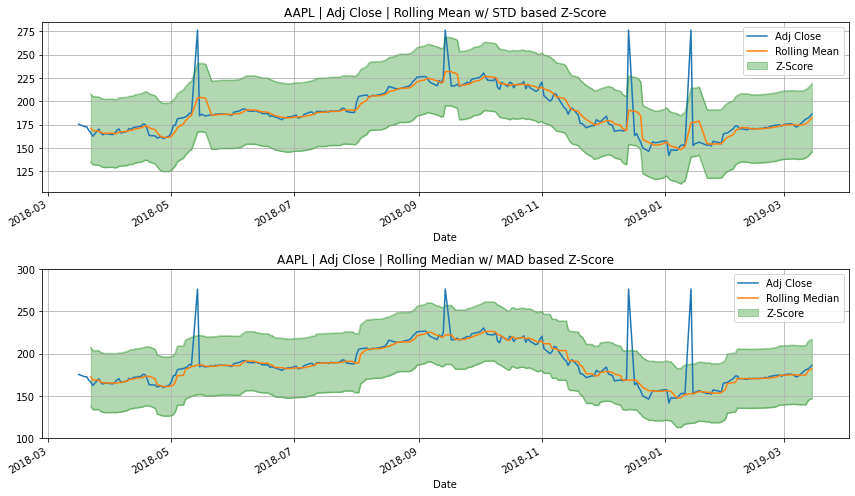

In [40]:
fig, axes = plt.subplots(2,1)

fig.set_figwidth(12)
fig.set_figheight(7)
AAPL_outlier['Adj Close'].plot(ax=axes[0], label='Adj Close')
AAPL_outlier['Adj Close'].rolling(5).mean().plot(ax=axes[0], label='Rolling Mean')
z_upper = AAPL_outlier['Adj Close'].rolling(5).mean() + 1.5*AAPL_outlier['Adj Close'].std()
z_upper.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
z_lower = AAPL_outlier['Adj Close'].rolling(5).mean() - 1.5*AAPL_outlier['Adj Close'].std()
z_lower.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
axes[0].fill_between(AAPL_outlier['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[0].legend()
axes[0].grid()
axes[0].set_title("AAPL | Adj Close | Rolling Mean w/ STD based Z-Score")

AAPL_outlier['Adj Close'].plot(ax=axes[1], label='Adj Close')
AAPL_outlier['Adj Close'].rolling(5).median().plot(ax=axes[1], label='Rolling Median')
z_upper = AAPL_outlier['Adj Close'].rolling(5).median() + 1.5*mad(AAPL_outlier['Adj Close'])
z_upper.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
z_lower = AAPL_outlier['Adj Close'].rolling(5).median() - 1.5*mad(AAPL_outlier['Adj Close'])
z_lower.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
axes[1].fill_between(AAPL_outlier['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[1].legend()
axes[1].grid()
axes[1].set_yticks(axes[0].get_yticks())
axes[1].set_title("AAPL | Adj Close | Rolling Median w/ MAD based Z-Score")


fig.tight_layout()

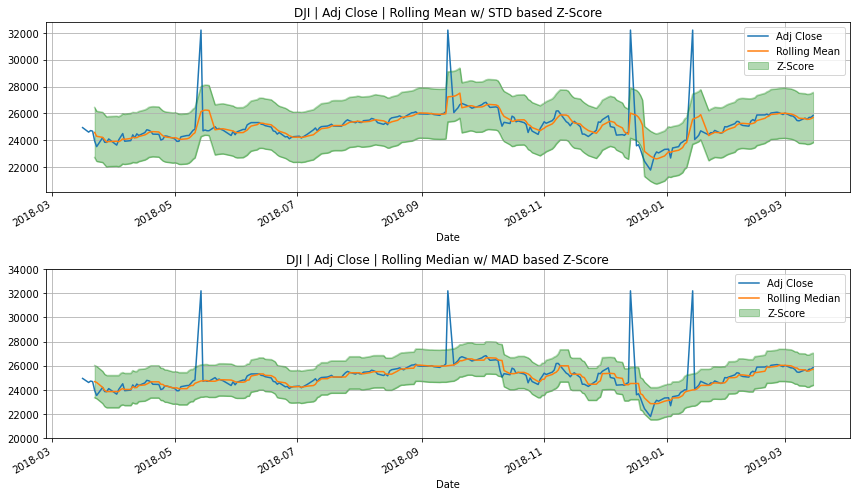

In [41]:
fig, axes = plt.subplots(2,1)

fig.set_figwidth(12)
fig.set_figheight(7)
DJI_outlier['Adj Close'].plot(ax=axes[0], label='Adj Close')
DJI_outlier['Adj Close'].rolling(5).mean().plot(ax=axes[0], label='Rolling Mean')
z_upper = DJI_outlier['Adj Close'].rolling(5).mean() + 1.5*DJI_outlier['Adj Close'].std()
z_upper.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
z_lower = DJI_outlier['Adj Close'].rolling(5).mean() - 1.5*DJI_outlier['Adj Close'].std()
z_lower.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
axes[0].fill_between(DJI_outlier['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[0].legend()
axes[0].grid()
axes[0].set_title("DJI | Adj Close | Rolling Mean w/ STD based Z-Score")

DJI_outlier['Adj Close'].plot(ax=axes[1], label='Adj Close')
DJI_outlier['Adj Close'].rolling(5).median().plot(ax=axes[1], label='Rolling Median')
z_upper = DJI_outlier['Adj Close'].rolling(5).median() + 1.5*mad(DJI_outlier['Adj Close'])
z_upper.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
z_lower = DJI_outlier['Adj Close'].rolling(5).median() - 1.5*mad(DJI_outlier['Adj Close'])
z_lower.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
axes[1].fill_between(DJI_outlier['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[1].legend()
axes[1].grid()
axes[1].set_yticks(axes[0].get_yticks())
axes[1].set_title("DJI | Adj Close | Rolling Median w/ MAD based Z-Score")


fig.tight_layout()

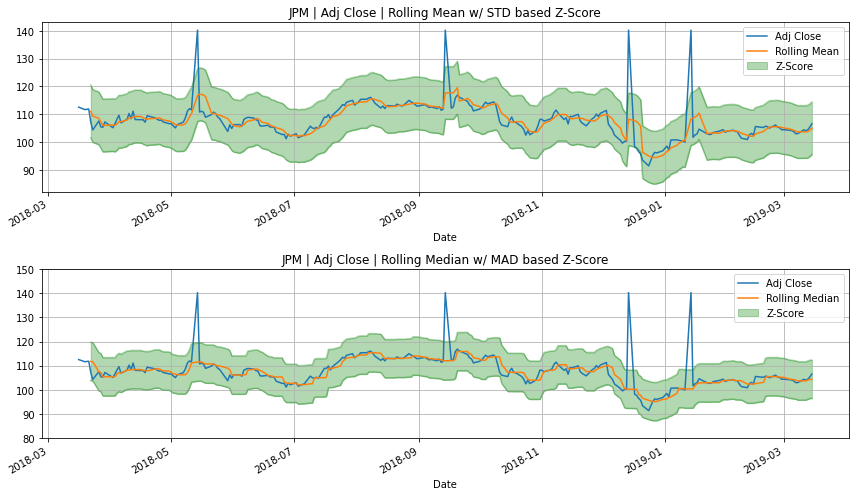

In [42]:
fig, axes = plt.subplots(2,1)

fig.set_figwidth(12)
fig.set_figheight(7)
JPM_outlier['Adj Close'].plot(ax=axes[0], label='Adj Close')
JPM_outlier['Adj Close'].rolling(5).mean().plot(ax=axes[0], label='Rolling Mean')
z_upper = JPM_outlier['Adj Close'].rolling(5).mean() + 1.5*JPM_outlier['Adj Close'].std()
z_upper.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
z_lower = JPM_outlier['Adj Close'].rolling(5).mean() - 1.5*JPM_outlier['Adj Close'].std()
z_lower.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
axes[0].fill_between(JPM_outlier['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[0].legend()
axes[0].grid()
axes[0].set_title("JPM | Adj Close | Rolling Mean w/ STD based Z-Score")

JPM_outlier['Adj Close'].plot(ax=axes[1], label='Adj Close')
JPM_outlier['Adj Close'].rolling(5).median().plot(ax=axes[1], label='Rolling Median')
z_upper = JPM_outlier['Adj Close'].rolling(5).median() + 1.5*mad(JPM_outlier['Adj Close'])
z_upper.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
z_lower = JPM_outlier['Adj Close'].rolling(5).median() - 1.5*mad(JPM_outlier['Adj Close'])
z_lower.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
axes[1].fill_between(JPM_outlier['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[1].legend()
axes[1].grid()
axes[1].set_yticks(axes[0].get_yticks())
axes[1].set_title("JPM | Adj Close | Rolling Median w/ MAD based Z-Score")


fig.tight_layout()

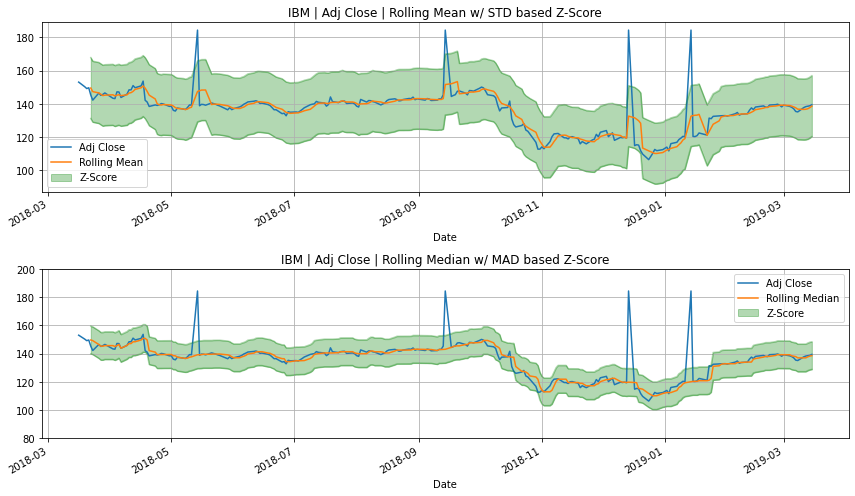

In [43]:
fig, axes = plt.subplots(2,1)

fig.set_figwidth(12)
fig.set_figheight(7)
IBM_outlier['Adj Close'].plot(ax=axes[0], label='Adj Close')
IBM_outlier['Adj Close'].rolling(5).mean().plot(ax=axes[0], label='Rolling Mean')
z_upper = IBM_outlier['Adj Close'].rolling(5).mean() + 1.5*IBM_outlier['Adj Close'].std()
z_upper.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
z_lower = IBM_outlier['Adj Close'].rolling(5).mean() - 1.5*IBM_outlier['Adj Close'].std()
z_lower.plot(ax=axes[0], color='g', alpha=0.3, label='_nolegend_')
axes[0].fill_between(IBM_outlier['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[0].legend()
axes[0].grid()
axes[0].set_title("IBM | Adj Close | Rolling Mean w/ STD based Z-Score")

IBM_outlier['Adj Close'].plot(ax=axes[1], label='Adj Close')
IBM_outlier['Adj Close'].rolling(5).median().plot(ax=axes[1], label='Rolling Median')
z_upper = IBM_outlier['Adj Close'].rolling(5).median() + 1.5*mad(IBM_outlier['Adj Close'])
z_upper.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
z_lower = IBM_outlier['Adj Close'].rolling(5).median() - 1.5*mad(IBM_outlier['Adj Close'])
z_lower.plot(ax=axes[1], color='g', alpha=0.3, label='_nolegend_')
axes[1].fill_between(IBM_outlier['Adj Close'].rolling(5).mean().index, z_lower, z_upper, color='g', alpha=0.3, label='Z-Score')
axes[1].legend()
axes[1].grid()
axes[1].set_yticks(axes[0].get_yticks())
axes[1].set_title("IBM | Adj Close | Rolling Median w/ MAD based Z-Score")


fig.tight_layout()

### 4.1.5 Box Plots for Ajd Close


In [ ]:
fig, axes = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(7)

AAPL_df['Adj Close'].plot.box(ax=axes[0][0])
axes[0][0].set_title('AAPL')

DJI_df['Adj Close'].plot.box(ax=axes[0][1])
axes[0][1].set_title('DJI')

JPM_df['Adj Close'].plot.box(ax=axes[1][0])
axes[1][0].set_title('JPM')

IBM_df['Adj Close'].plot.box(ax=axes[1][1])
axes[1][1].set_title('IBM')


fig.tight_layout()

## 4.2 Robust Estimators

### 4.2.1 Custom Estimators

In [ ]:
def MedianEstimator(series):
    tmp = series.sort_values()
    median = tmp[round(tmp.size/2)]
    return median

def IQREstimator(series):
    tmp = series.sort_values()
    Q1 = tmp[round(tmp.size/4)]
    Q3 = tmp[round(3*tmp.size/4)]
    return (Q3-Q1)

def MADEstimator(series)
    median = MedianEstimator(series)
    diff = abs(series-median)
    MAD = MedianEstimator(deviatons)
    return MAD

### 4.2.2 Complexity of Estimators
Median:    
Sorting - $O(nlog(n))$  
Access - $O(1)$ - Negligible  

IRQ:  
Sorting - $O(nlog(n))$  
Access 1 - $O(1)$  - Negligible  
Access 2 - $O(1)$  - Negligible  

MAD:  
Median Function: $O(nlog(n))$   
Calculate Diff: $O(n)$  
Median Function: $O(nlog(n))$ 

The MAD estimator takes the longest time computationally speaking

### 4.2.3 Breakdown Points of Estimators

Since estimators calculate some underlying statistics based on data, they are prone to error if the data itself is contaminated. The breakdown point of an estimator is the number of data points that can be changed/contaminated before the statistic changes by an arbitarly large amount. Since the median takes the middle point of a sorted list, upto 50% of the data points can be contaminated before the median will drastically change. Since MAD also uses the median estimator to calculate it's value it also has a breakdown point of 50%. IRQ, on the other hand, has a breakdown of 25% since after that point either the first quarter value, or the last quarter value will have changed drastically.

## 4.3 Robust and OLS regression


### 4.3.1 Regression on DLI

In [4]:
DJI_returns = DJI_df['Returns'].copy().dropna().values.reshape(-1,1)
AAPL_returns  = AAPL_df['Returns'].copy().dropna().values.reshape(-1,1)
IBM_returns  = IBM_df['Returns'].copy().dropna().values.reshape(-1,1)
JPM_returns  = JPM_df['Returns'].copy().dropna().values.reshape(-1,1)

regression_error = pd.DataFrame(index=['OLS', 'HR'], columns=['AAPL','IBM','JPM'])

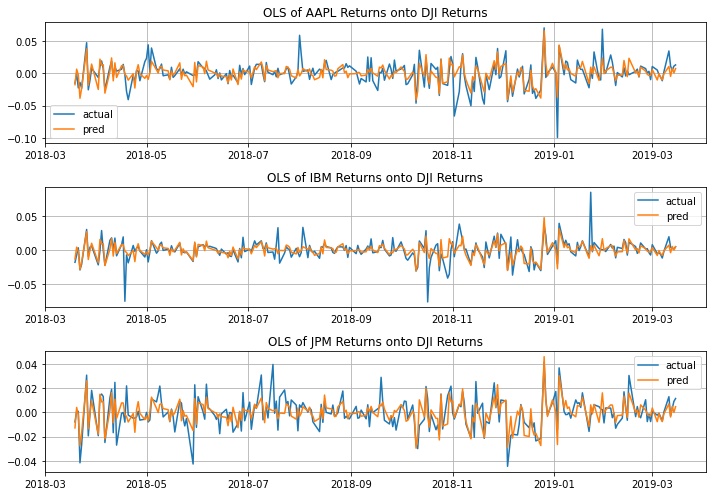

In [5]:
OLS = linear_model.LinearRegression()
fig, axes = plt.subplots(3,1)

OLS.fit(DJI_returns, AAPL_returns)
axes[0].plot(AAPL_df.index[1:], AAPL_returns)
axes[0].plot(AAPL_df.index[1:], OLS.predict(DJI_returns))
axes[0].legend(['actual', 'pred'])
axes[0].grid()
axes[0].set_title('OLS of AAPL Returns onto DJI Returns')
regression_error['AAPL']['OLS'] = mean_squared_error(AAPL_returns, OLS.predict(DJI_returns))

OLS.fit(DJI_returns, IBM_returns)
axes[1].plot(IBM_df.index[1:], IBM_returns)
axes[1].plot(IBM_df.index[1:], OLS.predict(DJI_returns))
axes[1].legend(['actual', 'pred'])
axes[1].grid()
axes[1].set_title('OLS of IBM Returns onto DJI Returns')
regression_error['IBM']['OLS'] = mean_squared_error(IBM_returns, OLS.predict(DJI_returns))

OLS.fit(DJI_returns, JPM_returns)
axes[2].plot(IBM_df.index[1:], JPM_returns)
axes[2].plot(IBM_df.index[1:], OLS.predict(DJI_returns))
axes[2].legend(['actual', 'pred'])
axes[2].grid()
axes[2].set_title('OLS of JPM Returns onto DJI Returns')
regression_error['JPM']['OLS'] = mean_squared_error(JPM_returns, OLS.predict(DJI_returns))

fig.set_figwidth(10)
fig.set_figheight(7)
fig.tight_layout()

### 4.3.3

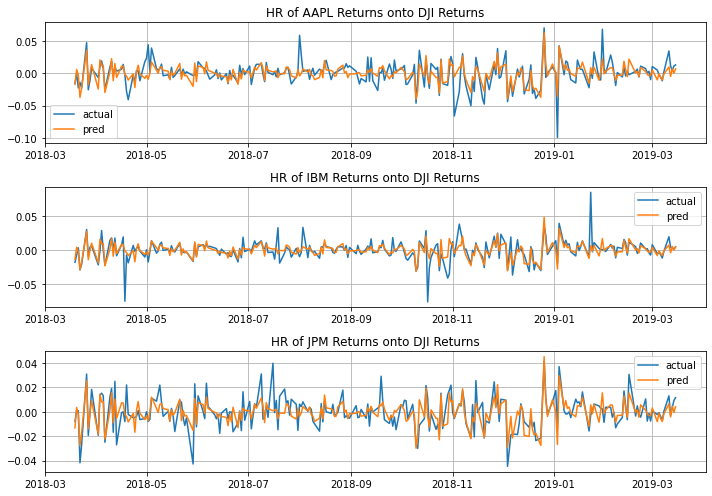

In [6]:
HR = linear_model.HuberRegressor()
fig, axes = plt.subplots(3,1)

HR.fit(DJI_returns, AAPL_returns)
axes[0].plot(AAPL_df.index[1:], AAPL_returns)
axes[0].plot(AAPL_df.index[1:], HR.predict(DJI_returns))
axes[0].legend(['actual', 'pred'])
axes[0].grid()
axes[0].set_title('HR of AAPL Returns onto DJI Returns')
regression_error['AAPL']['HR'] = mean_squared_error(AAPL_returns, OLS.predict(DJI_returns))

HR.fit(DJI_returns, IBM_returns)
axes[1].plot(IBM_df.index[1:], IBM_returns)
axes[1].plot(IBM_df.index[1:], HR.predict(DJI_returns))
axes[1].legend(['actual', 'pred'])
axes[1].grid()
axes[1].set_title('HR of IBM Returns onto DJI Returns')
regression_error['IBM']['HR'] = mean_squared_error(IBM_returns, OLS.predict(DJI_returns))

HR.fit(DJI_returns, JPM_returns)
axes[2].plot(IBM_df.index[1:], JPM_returns)
axes[2].plot(IBM_df.index[1:], HR.predict(DJI_returns))
axes[2].legend(['actual', 'pred'])
axes[2].grid()
axes[2].set_title('HR of JPM Returns onto DJI Returns')
regression_error['JPM']['HR'] = mean_squared_error(JPM_returns, OLS.predict(DJI_returns))

fig.set_figwidth(10)
fig.set_figheight(7)
fig.tight_layout()

### 4.3.3 Error and Outliers

In [7]:
regression_error

,AAPL,IBM,JPM
OLS,0.0001798,0.000140431,7.57723e-05
HR,0.000197097,0.000140535,7.57723e-05


In [8]:
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']
AAPL_outlier = AAPL_df.copy()
DJI_outlier = DJI_df.copy()
JPM_outlier = JPM_df.copy()
IBM_outlier = IBM_df.copy()

AAPL_max = AAPL_outlier['Adj Close'].max()*1.2
DJI_max = DJI_outlier['Adj Close'].max()*1.2
IBM_max = IBM_outlier['Adj Close'].max()*1.2
JPM_max = JPM_outlier['Adj Close'].max()*1.2

for date in dates:
    AAPL_outlier['Adj Close'][date] = AAPL_max
    DJI_outlier['Adj Close'][date] = DJI_max
    IBM_outlier['Adj Close'][date] = IBM_max
    JPM_outlier['Adj Close'][date] = JPM_max

DJI_returns  = DJI_outlier['Returns'].copy().dropna().values.reshape(-1,1)
AAPL_returns = AAPL_outlier['Returns'].copy().dropna().values.reshape(-1,1)
IBM_returns  = IBM_outlier['Returns'].copy().dropna().values.reshape(-1,1)
JPM_returns  = JPM_outlier['Returns'].copy().dropna().values.reshape(-1,1)

outlier_regression_error = pd.DataFrame(index=['OLS', 'HR'], columns=['AAPL','IBM','JPM'])
OLS = linear_model.LinearRegression()
HR = linear_model.HuberRegressor()

OLS.fit(DJI_returns, AAPL_returns)
OLS.predict(DJI_returns)
outlier_regression_error['AAPL']['OLS'] = mean_squared_error(AAPL_returns, OLS.predict(DJI_returns))

OLS.fit(DJI_returns, IBM_returns)
OLS.predict(DJI_returns)
outlier_regression_error['IBM']['OLS'] = mean_squared_error(IBM_returns, OLS.predict(DJI_returns))

OLS.fit(DJI_returns, JPM_returns)
OLS.predict(DJI_returns)
outlier_regression_error['JPM']['OLS'] = mean_squared_error(JPM_returns, OLS.predict(DJI_returns))

HR.fit(DJI_returns, AAPL_returns)
OLS.predict(DJI_returns)
outlier_regression_error['AAPL']['HR'] = mean_squared_error(AAPL_returns, OLS.predict(DJI_returns))

HR.fit(DJI_returns, IBM_returns)
OLS.predict(DJI_returns)
outlier_regression_error['IBM']['HR'] = mean_squared_error(IBM_returns, OLS.predict(DJI_returns))

HR.fit(DJI_returns, JPM_returns)
OLS.predict(DJI_returns)
outlier_regression_error['JPM']['HR'] = mean_squared_error(JPM_returns, OLS.predict(DJI_returns))

outlier_regression_error

,AAPL,IBM,JPM
OLS,0.000178924,0.000168406,7.50725e-05
HR,0.000229238,0.000211352,7.50725e-05


## 4.4 Robust Trading Strategies

Talk about how the strategy doesn't change when using median, thus making it more robust



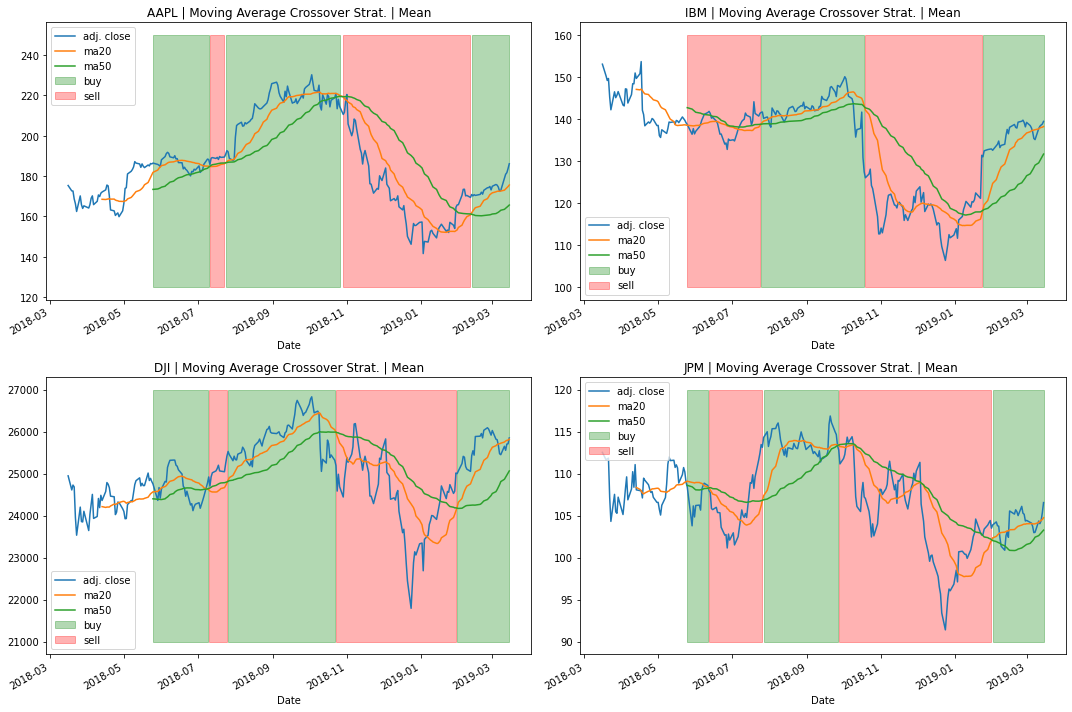

In [44]:
fig, axes = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(10)

AAPL_ma20 = AAPL_df['Adj Close'].rolling(20).mean()
AAPL_ma50 = AAPL_df['Adj Close'].rolling(50).mean()
AAPL_df['Adj Close'].plot(ax=axes[0][0], label='adj. close')
AAPL_ma20.plot(ax=axes[0][0], label='ma20')
AAPL_ma50.plot(ax=axes[0][0], label='ma50')
axes[0][0].fill_between(AAPL_df.index, 250, 125, where=AAPL_ma20 > AAPL_ma50, label='buy', color='g', alpha=0.3)
axes[0][0].fill_between(AAPL_df.index, 250, 125, where=AAPL_ma20 < AAPL_ma50, label='sell', color='r',  alpha=0.3)
axes[0][0].legend(loc='upper left')
axes[0][0].set_title('AAPL | Moving Average Crossover Strat. | Mean')

IBM_ma20 = IBM_df['Adj Close'].rolling(20).mean()
IBM_ma50 = IBM_df['Adj Close'].rolling(50).mean()
IBM_df['Adj Close'].plot(ax=axes[0][1], label='adj. close')
IBM_ma20.plot(ax=axes[0][1], label='ma20')
IBM_ma50.plot(ax=axes[0][1], label='ma50')
axes[0][1].fill_between(IBM_df.index, 160, 100, where=IBM_ma20 > IBM_ma50, label='buy', color='g', alpha=0.3)
axes[0][1].fill_between(IBM_df.index, 160, 100, where=IBM_ma20 < IBM_ma50, label='sell', color='r',  alpha=0.3)
axes[0][1].legend(loc='lower left')
axes[0][1].set_title('IBM | Moving Average Crossover Strat. | Mean')

DJI_ma20 = DJI_df['Adj Close'].rolling(20).mean()
DJI_ma50 = DJI_df['Adj Close'].rolling(50).mean()
DJI_df['Adj Close'].plot(ax=axes[1][0], label='adj. close')
DJI_ma20.plot(ax=axes[1][0], label='ma20')
DJI_ma50.plot(ax=axes[1][0], label='ma50')
axes[1][0].fill_between(DJI_df.index, 27000, 21000, where=DJI_ma20 > DJI_ma50, label='buy', color='g', alpha=0.3)
axes[1][0].fill_between(DJI_df.index, 27000, 21000, where=DJI_ma20 < DJI_ma50, label='sell', color='r',  alpha=0.3)
axes[1][0].legend(loc='lower left')
axes[1][0].set_title('DJI | Moving Average Crossover Strat. | Mean')

JPM_ma20 = JPM_df['Adj Close'].rolling(20).mean()
JPM_ma50 = JPM_df['Adj Close'].rolling(50).mean()
JPM_df['Adj Close'].plot(ax=axes[1][1], label='adj. close')
JPM_ma20.plot(ax=axes[1][1], label='ma20')
JPM_ma50.plot(ax=axes[1][1], label='ma50')
axes[1][1].fill_between(JPM_df.index, 120, 90, where=JPM_ma20 > JPM_ma50, label='buy', color='g', alpha=0.3)
axes[1][1].fill_between(JPM_df.index, 120, 90, where=JPM_ma20 < JPM_ma50, label='sell', color='r',  alpha=0.3)
axes[1][1].legend(loc='upper left')
axes[1][1].set_title('JPM | Moving Average Crossover Strat. | Mean ')

fig.tight_layout()

#### Adding Corruption

In [45]:
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']
AAPL_outlier = AAPL_df.copy()
DJI_outlier = DJI_df.copy()
JPM_outlier = JPM_df.copy()
IBM_outlier = IBM_df.copy()

AAPL_max = AAPL_outlier['Adj Close'].max()*1.2
DJI_max = DJI_outlier['Adj Close'].max()*1.2
IBM_max = IBM_outlier['Adj Close'].max()*1.2
JPM_max = JPM_outlier['Adj Close'].max()*1.2

for date in dates:
    AAPL_outlier['Adj Close'][date] = AAPL_max
    DJI_outlier['Adj Close'][date] = DJI_max
    IBM_outlier['Adj Close'][date] = IBM_max
    JPM_outlier['Adj Close'][date] = JPM_max

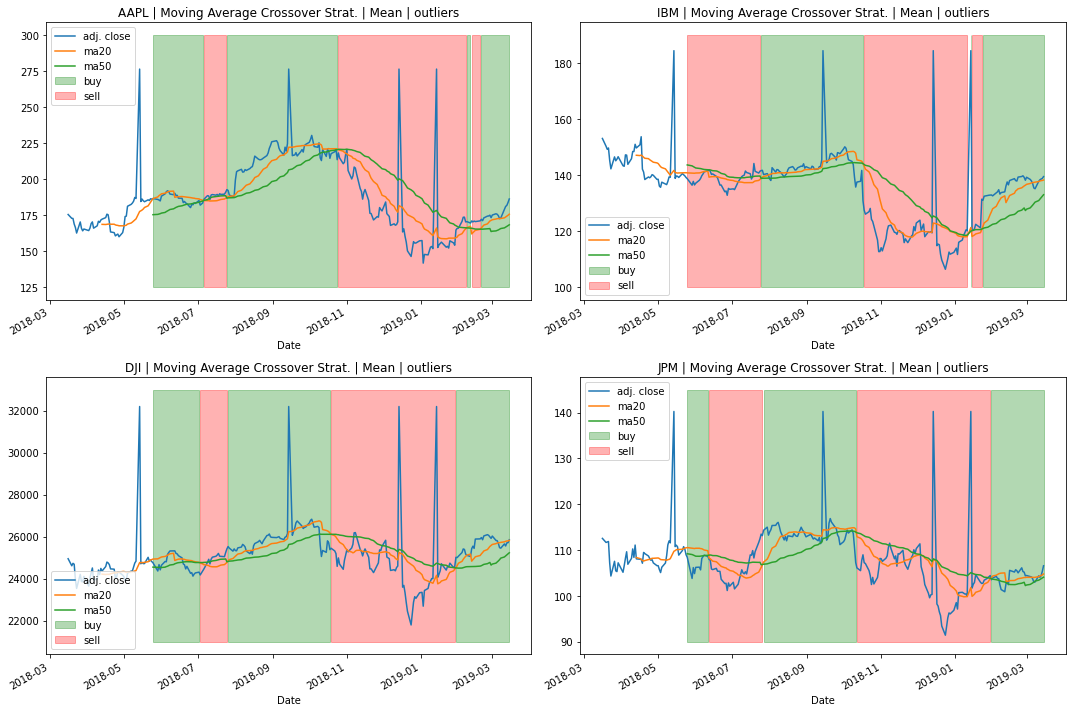

In [46]:
fig, axes = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(10)

AAPL_ma20 = AAPL_outlier['Adj Close'].rolling(20).mean()
AAPL_ma50 = AAPL_outlier['Adj Close'].rolling(50).mean()
AAPL_outlier['Adj Close'].plot(ax=axes[0][0], label='adj. close')
AAPL_ma20.plot(ax=axes[0][0], label='ma20')
AAPL_ma50.plot(ax=axes[0][0], label='ma50')
axes[0][0].fill_between(AAPL_outlier.index, 300, 125, where=AAPL_ma20 > AAPL_ma50, label='buy', color='g', alpha=0.3)
axes[0][0].fill_between(AAPL_outlier.index, 300, 125, where=AAPL_ma20 < AAPL_ma50, label='sell', color='r',  alpha=0.3)
axes[0][0].legend(loc='upper left')
axes[0][0].set_title('AAPL | Moving Average Crossover Strat. | Mean | outliers')

IBM_ma20 = IBM_outlier['Adj Close'].rolling(20).mean()
IBM_ma50 = IBM_outlier['Adj Close'].rolling(50).mean()
IBM_outlier['Adj Close'].plot(ax=axes[0][1], label='adj. close')
IBM_ma20.plot(ax=axes[0][1], label='ma20')
IBM_ma50.plot(ax=axes[0][1], label='ma50')
axes[0][1].fill_between(IBM_outlier.index, 190, 100, where=IBM_ma20 > IBM_ma50, label='buy', color='g', alpha=0.3)
axes[0][1].fill_between(IBM_outlier.index, 190, 100, where=IBM_ma20 < IBM_ma50, label='sell', color='r',  alpha=0.3)
axes[0][1].legend(loc='lower left')
axes[0][1].set_title('IBM | Moving Average Crossover Strat. | Mean | outliers')

DJI_ma20 = DJI_outlier['Adj Close'].rolling(20).mean()
DJI_ma50 = DJI_outlier['Adj Close'].rolling(50).mean()
DJI_outlier['Adj Close'].plot(ax=axes[1][0], label='adj. close')
DJI_ma20.plot(ax=axes[1][0], label='ma20')
DJI_ma50.plot(ax=axes[1][0], label='ma50')
axes[1][0].fill_between(DJI_outlier.index, 33000, 21000, where=DJI_ma20 > DJI_ma50, label='buy', color='g', alpha=0.3)
axes[1][0].fill_between(DJI_outlier.index, 33000, 21000, where=DJI_ma20 < DJI_ma50, label='sell', color='r',  alpha=0.3)
axes[1][0].legend(loc='lower left')
axes[1][0].set_title('DJI | Moving Average Crossover Strat. | Mean | outliers')

JPM_ma20 = JPM_outlier['Adj Close'].rolling(20).mean()
JPM_ma50 = JPM_outlier['Adj Close'].rolling(50).mean()
JPM_outlier['Adj Close'].plot(ax=axes[1][1], label='adj. close')
JPM_ma20.plot(ax=axes[1][1], label='ma20')
JPM_ma50.plot(ax=axes[1][1], label='ma50')
axes[1][1].fill_between(JPM_outlier.index, 145, 90, where=JPM_ma20 > JPM_ma50, label='buy', color='g', alpha=0.3)
axes[1][1].fill_between(JPM_outlier.index, 145, 90, where=JPM_ma20 < JPM_ma50, label='sell', color='r',  alpha=0.3)
axes[1][1].legend(loc='upper left')
axes[1][1].set_title('JPM | Moving Average Crossover Strat. | Mean | outliers')

fig.tight_layout()

### 4.4.2 Median MAC

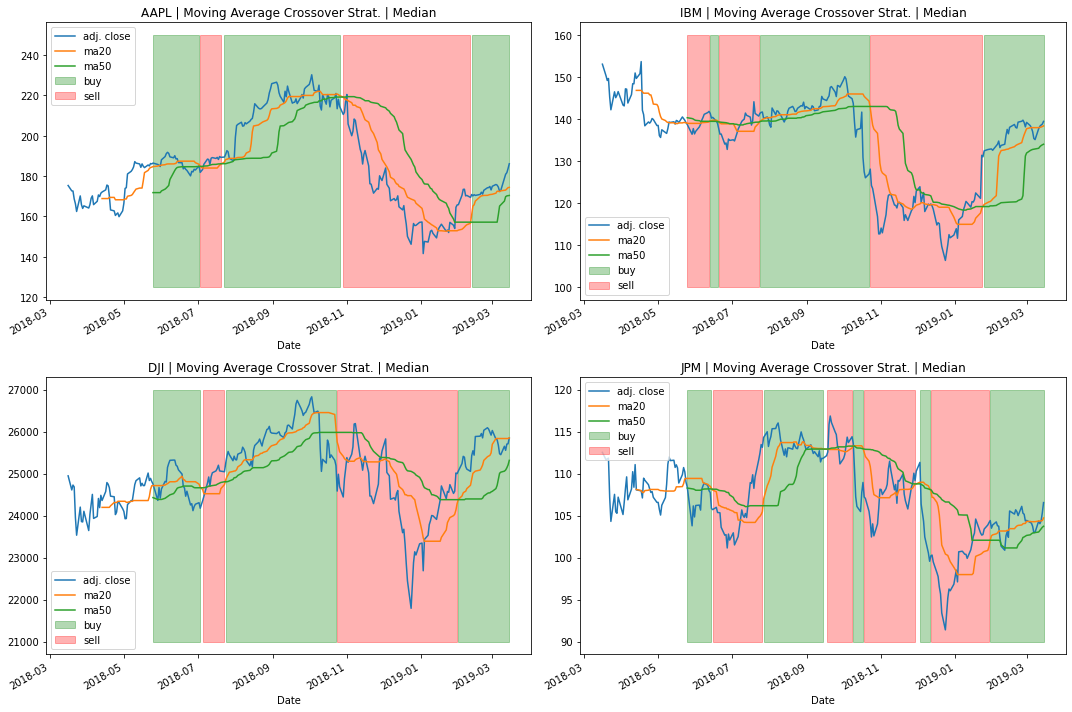

In [47]:
fig, axes = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(10)

AAPL_ma20 = AAPL_df['Adj Close'].rolling(20).median()
AAPL_ma50 = AAPL_df['Adj Close'].rolling(50).median()
AAPL_df['Adj Close'].plot(ax=axes[0][0], label='adj. close')
AAPL_ma20.plot(ax=axes[0][0], label='ma20')
AAPL_ma50.plot(ax=axes[0][0], label='ma50')
axes[0][0].fill_between(AAPL_df.index, 250, 125, where=AAPL_ma20 > AAPL_ma50, label='buy', color='g', alpha=0.3)
axes[0][0].fill_between(AAPL_df.index, 250, 125, where=AAPL_ma20 < AAPL_ma50, label='sell', color='r',  alpha=0.3)
axes[0][0].legend(loc='upper left')
axes[0][0].set_title('AAPL | Moving Average Crossover Strat. | Median')

IBM_ma20 = IBM_df['Adj Close'].rolling(20).median()
IBM_ma50 = IBM_df['Adj Close'].rolling(50).median()
IBM_df['Adj Close'].plot(ax=axes[0][1], label='adj. close')
IBM_ma20.plot(ax=axes[0][1], label='ma20')
IBM_ma50.plot(ax=axes[0][1], label='ma50')
axes[0][1].fill_between(IBM_df.index, 160, 100, where=IBM_ma20 > IBM_ma50, label='buy', color='g', alpha=0.3)
axes[0][1].fill_between(IBM_df.index, 160, 100, where=IBM_ma20 < IBM_ma50, label='sell', color='r',  alpha=0.3)
axes[0][1].legend(loc='lower left')
axes[0][1].set_title('IBM | Moving Average Crossover Strat. | Median')

DJI_ma20 = DJI_df['Adj Close'].rolling(20).median()
DJI_ma50 = DJI_df['Adj Close'].rolling(50).median()
DJI_df['Adj Close'].plot(ax=axes[1][0], label='adj. close')
DJI_ma20.plot(ax=axes[1][0], label='ma20')
DJI_ma50.plot(ax=axes[1][0], label='ma50')
axes[1][0].fill_between(DJI_df.index, 27000, 21000, where=DJI_ma20 > DJI_ma50, label='buy', color='g', alpha=0.3)
axes[1][0].fill_between(DJI_df.index, 27000, 21000, where=DJI_ma20 < DJI_ma50, label='sell', color='r',  alpha=0.3)
axes[1][0].legend(loc='lower left')
axes[1][0].set_title('DJI | Moving Average Crossover Strat. | Median')

JPM_ma20 = JPM_df['Adj Close'].rolling(20).median()
JPM_ma50 = JPM_df['Adj Close'].rolling(50).median()
JPM_df['Adj Close'].plot(ax=axes[1][1], label='adj. close')
JPM_ma20.plot(ax=axes[1][1], label='ma20')
JPM_ma50.plot(ax=axes[1][1], label='ma50')
axes[1][1].fill_between(JPM_df.index, 120, 90, where=JPM_ma20 > JPM_ma50, label='buy', color='g', alpha=0.3)
axes[1][1].fill_between(JPM_df.index, 120, 90, where=JPM_ma20 < JPM_ma50, label='sell', color='r',  alpha=0.3)
axes[1][1].legend(loc='upper left')
axes[1][1].set_title('JPM | Moving Average Crossover Strat. | Median')

fig.tight_layout()

#### Introducing Outliers

In [48]:
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']
AAPL_outlier = AAPL_df.copy()
DJI_outlier = DJI_df.copy()
JPM_outlier = JPM_df.copy()
IBM_outlier = IBM_df.copy()

AAPL_max = AAPL_outlier['Adj Close'].max()*1.2
DJI_max = DJI_outlier['Adj Close'].max()*1.2
IBM_max = IBM_outlier['Adj Close'].max()*1.2
JPM_max = JPM_outlier['Adj Close'].max()*1.2

for date in dates:
    AAPL_outlier['Adj Close'][date] = AAPL_max
    DJI_outlier['Adj Close'][date] = DJI_max
    IBM_outlier['Adj Close'][date] = IBM_max
    JPM_outlier['Adj Close'][date] = JPM_max

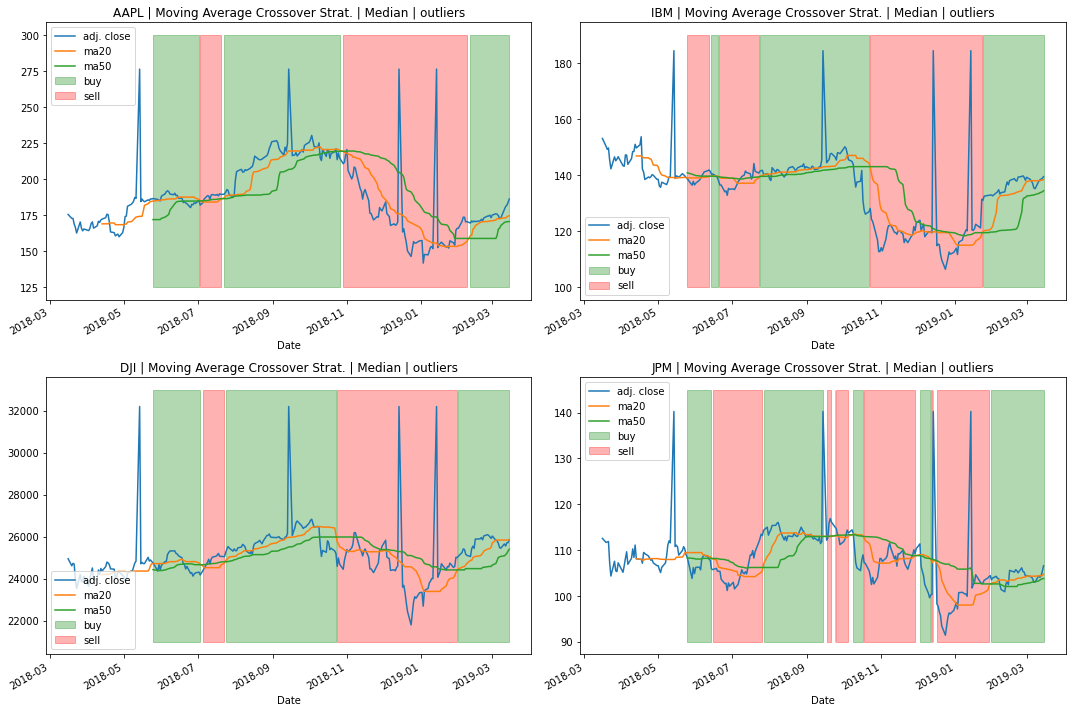

In [49]:
fig, axes = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(10)

AAPL_ma20 = AAPL_outlier['Adj Close'].rolling(20).median()
AAPL_ma50 = AAPL_outlier['Adj Close'].rolling(50).median()
AAPL_outlier['Adj Close'].plot(ax=axes[0][0], label='adj. close')
AAPL_ma20.plot(ax=axes[0][0], label='ma20')
AAPL_ma50.plot(ax=axes[0][0], label='ma50')
axes[0][0].fill_between(AAPL_outlier.index, 300, 125, where=AAPL_ma20 > AAPL_ma50, label='buy', color='g', alpha=0.3)
axes[0][0].fill_between(AAPL_outlier.index, 300, 125, where=AAPL_ma20 < AAPL_ma50, label='sell', color='r',  alpha=0.3)
axes[0][0].legend(loc='upper left')
axes[0][0].set_title('AAPL | Moving Average Crossover Strat. | Median | outliers')

IBM_ma20 = IBM_outlier['Adj Close'].rolling(20).median()
IBM_ma50 = IBM_outlier['Adj Close'].rolling(50).median()
IBM_outlier['Adj Close'].plot(ax=axes[0][1], label='adj. close')
IBM_ma20.plot(ax=axes[0][1], label='ma20')
IBM_ma50.plot(ax=axes[0][1], label='ma50')
axes[0][1].fill_between(IBM_outlier.index, 190, 100, where=IBM_ma20 > IBM_ma50, label='buy', color='g', alpha=0.3)
axes[0][1].fill_between(IBM_outlier.index, 190, 100, where=IBM_ma20 < IBM_ma50, label='sell', color='r',  alpha=0.3)
axes[0][1].legend(loc='lower left')
axes[0][1].set_title('IBM | Moving Average Crossover Strat. | Median | outliers')

DJI_ma20 = DJI_outlier['Adj Close'].rolling(20).median()
DJI_ma50 = DJI_outlier['Adj Close'].rolling(50).median()
DJI_outlier['Adj Close'].plot(ax=axes[1][0], label='adj. close')
DJI_ma20.plot(ax=axes[1][0], label='ma20')
DJI_ma50.plot(ax=axes[1][0], label='ma50')
axes[1][0].fill_between(DJI_outlier.index, 33000, 21000, where=DJI_ma20 > DJI_ma50, label='buy', color='g', alpha=0.3)
axes[1][0].fill_between(DJI_outlier.index, 33000, 21000, where=DJI_ma20 < DJI_ma50, label='sell', color='r',  alpha=0.3)
axes[1][0].legend(loc='lower left')
axes[1][0].set_title('DJI | Moving Average Crossover Strat. | Median | outliers')

JPM_ma20 = JPM_outlier['Adj Close'].rolling(20).median()
JPM_ma50 = JPM_outlier['Adj Close'].rolling(50).median()
JPM_outlier['Adj Close'].plot(ax=axes[1][1], label='adj. close')
JPM_ma20.plot(ax=axes[1][1], label='ma20')
JPM_ma50.plot(ax=axes[1][1], label='ma50')
axes[1][1].fill_between(JPM_outlier.index, 145, 90, where=JPM_ma20 > JPM_ma50, label='buy', color='g', alpha=0.3)
axes[1][1].fill_between(JPM_outlier.index, 145, 90, where=JPM_ma20 < JPM_ma50, label='sell', color='r',  alpha=0.3)
axes[1][1].legend(loc='upper left')
axes[1][1].set_title('JPM | Moving Average Crossover Strat. | Median | outliers')

fig.tight_layout()